# **🥭Fruit Grading | VGG16 | Acc: 84% 📈**

## **Introduction 👨🏻‍🏫**

🔍This model was built to enable the InFruit app's detecting feature. This model classifies images using transfer learning. Transfer learning uses a pre-trained model, which has already been trained on a large dataset over an extended period, as a starting point to train a new model on a smaller, task-specific dataset🤖. This saves time ⏱️ and resources when data is limited.The model is evaluated and fine-tuned for accuracy before being used to categorize new images. This model consists of three labels that identify mangoes quality 🥭 as class I, class II, or extra class. The trained model then deployed using TFLite.

## **Modules** 📑

In [ ]:
# Prerequisites to visualizing activations and gradients in neural networks built with TensorFlow's Keras API
!pip install tf-keras-vis

In [ ]:
# Prerequisites to TFLite Metadata Writing
!pip install tflite-support-nightly

In [ ]:
# Common Imports
import os
import zipfile
import random
import shutil
import numpy as np
from shutil import copyfile

# Data Visualization
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras Imports
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

# Explainable AI (XAI) and Visualization of Model Predictions
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# TFLite Metadata Writing
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

# Camera Capture
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from PIL import Image
import io
import cv2
import time

In [ ]:
print(tf.__version__)

In [ ]:
# Upload Kaggle Cookies
files.upload()

## **Data Preprocessing** 🧰

### **About Dataset**

🥭 The Mango Varieties Classification and Grading dataset is a collection of **over 2,000 images** of eight varieties of Pakistani mangoes, as well as its grade. The images were acquired with high resolution and constant lighting to help the model extract the feature during training.

📊📉 The original dataset is split into two sets: classification dataset and grading dataset. Due to the purpose of our application, we only use the grading dataset for this model. However, the Python script provided with the dataset can be used to create the train, validation, and test sets by shuffling the images and moving them to their respective directories. Each class of this grading dataset is also split into three caterogies, including class I, class II, and extra class to ensure a consistent distribution of classes across all sets.

Below is the explanation for every categories:⬇️⬇️

Grading of mangoes is performed based on size, color, and texture, following international standards which categorize mangoes into three classes:

***Extra Class*** : Superior quality with minimal defects.

***Class I*** : Good quality with slight skin defects.

***Class II*** : Does not qualify for higher classes but meets minimum quality requirements.

🌐 The full dataset can be found on this Kaggle link: [Mango Varieties Classification and Grading🥭](https://www.kaggle.com/datasets/saurabhshahane/mango-varieties-classification)

In [ ]:
!wget --no-check-certificate -x --load-cookies cookies.txt \
  "https://www.kaggle.com/datasets/saurabhshahane/mango-varieties-classification/download" \
  -O /tmp/data.zip

### **Dataset Structure**

In [ ]:
# Extract zip file
local_zip = '/tmp/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

This code serves to delete the "**classification dataset**" folder since we only use the "**grading dataset**" to train this model ❌

In [ ]:
# Specify the folder path "classification dataset"
classification_folder = '/tmp/Dataset/Classification_dataset'

# Delete "classification dataset" folder if any
if os.path.exists(classification_folder) and os.path.isdir(classification_folder):
    shutil.rmtree(classification_folder)
    print(f'Folder "{classification_folder}" telah dihapus.')
else:
    print(f'Folder "{classification_folder}" tidak ditemukan.')

Folder "/tmp/Dataset/Classification_dataset" telah dihapus.


In [ ]:
# Specify the path to the directory where the files have been extracted
extracted_dir = '/tmp'

# Function to print only folders in a directory recursively without duplication
def list_folders(startpath):
    seen_folders = set()

    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        current_folder = os.path.basename(root)

        # If the folder is already visible, skip
        if current_folder in seen_folders:
            continue

        print(f'{indent}{current_folder}/')
        seen_folders.add(current_folder)

        for d in dirs:
            subindent = ' ' * 4 * (level + 1)
            sub_folder = os.path.join(root, d)
            sub_folder_name = os.path.basename(sub_folder)

            # If the subfolder is already visible, skip
            if sub_folder_name in seen_folders:
                continue

            print(f'{subindent}{sub_folder_name}/')
            seen_folders.add(sub_folder_name)

# Call the function to print only the folder
list_folders(extracted_dir)

tmp/
    tmp_7ftjy5n/
    pyright-236-DdRWFamqtWix/
    Dataset/
    tmpc18b3cze/
    python-languageserver-cancellation/
    pyright-236-jM8HWnZb1lOX/
    initgoogle_syslog_dir.0/
        Grading_dataset/
            Class_I/
            Extra_Class/
            Class_II/
        d8cdec80cf621d5913e478f3fbf0b626c6847dac4e/


In [ ]:
def make_dir(PATH):
  if not os.path.exists(PATH):
      os.mkdir(PATH)
      return PATH
  else:
    shutil.rmtree(PATH)
    os.mkdir(PATH)
    return PATH

### **Split Dataset**

In [ ]:
def split_data(base_dir, output_dir, train_ratio=0.8, test_ratio=0.1, val_ratio=0.1):
    if train_ratio + test_ratio + val_ratio != 1.0:
        raise ValueError("Total ratio must be 1.0")

    # Path to train, test, and validation folders
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')
    val_dir = os.path.join(output_dir, 'validation')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # List all subfolders in base_dir
    categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for category in categories:
        category_dir = os.path.join(base_dir, category)
        images = os.listdir(category_dir)
        random.shuffle(images)

        train_split = int(train_ratio * len(images))
        test_split = int(test_ratio * len(images))

        train_images = images[:train_split]
        test_images = images[train_split:train_split + test_split]
        val_images = images[train_split + test_split:]

        # Create directories for categories in train, test, and validation
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)

        # Move the image to the appropriate directory
        for image in train_images:
            shutil.copy(os.path.join(category_dir, image), os.path.join(train_dir, category, image))

        for image in test_images:
            shutil.copy(os.path.join(category_dir, image), os.path.join(test_dir, category, image))

        for image in val_images:
            shutil.copy(os.path.join(category_dir, image), os.path.join(val_dir, category, image))

# Path to the original data directory
base_dir = '/tmp/Dataset/Grading_dataset'

# Path to output directory for train, test, and validation
output_dir = '/tmp/Grading_Split/'

# Call the function to split the data
split_data(base_dir, output_dir)

In [ ]:
def check_split(output_dir):
    splits = ['train', 'test', 'validation']
    for split in splits:
        split_dir = os.path.join(output_dir, split)
        if not os.path.exists(split_dir):
            print(f"{split_dir} does not exist.")
            continue

        print(f"\nChecking {split} data:")

        total_images = 0
        categories = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
        for category in categories:
            category_dir = os.path.join(split_dir, category)
            num_images = len([f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))])
            total_images += num_images
            print(f"  {category}: {num_images} images")

        print(f"Total {split} images: {total_images}")

# Path to output directory for train, test, and validation
output_dir = '/tmp/Grading_Split/'

# Call the function to check the split data
check_split(output_dir)


Checking train data:
  Class_I: 160 images
  Extra_Class: 160 images
  Class_II: 160 images
Total train images: 480

Checking test data:
  Class_I: 20 images
  Extra_Class: 20 images
  Class_II: 20 images
Total test images: 60

Checking validation data:
  Class_I: 20 images
  Extra_Class: 20 images
  Class_II: 20 images
Total validation images: 60


### **Data Augmentation**

In [ ]:
# Define augmentation parameters for training
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=30,            # Slightly increased rotation range
    width_shift_range=0.1,        # Increased horizontal shift
    height_shift_range=0.1,       # Increased vertical shift
    zoom_range=0.1,               # Increased zoom range
    horizontal_flip=True,         # Keep horizontal flip
    vertical_flip=True,           # Keep vertical flip
    brightness_range=[0.8, 1.2],  # Slightly wider brightness adjustment
    fill_mode='nearest'           # Fill in new pixels with the nearest value
)

# Define ImageDataGenerator for validation and test with only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Path to the directory of the split and augmented dataset
base_dir = '/tmp/Grading_Split/'

# Prepare the generator for training
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),  # Adjust to the desired image size
    batch_size=10,           # Adjust to the desired batch size
    class_mode='categorical' # Customize with your label type, either 'binary' or 'categorical'
)

# Prepare the generator for validation
validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical'
)

# Prepare the generator for test
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical',
    shuffle=False  # No need to shuffle for test set
)

In [ ]:
# Determine the number of classes based on train_generator
num_classes = len(train_generator.class_indices)

## **Model Architecture** 👷🏻‍♀️

### **Training Model**

In [ ]:
# Load the VGG16 model pretrained on ImageNet, include_top=False removes the fully connected layer at the top
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
base_model.trainable = False

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train model dengan generator
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks
)

# Evaluate model dengan test generator
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

Found 480 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Epoch 1/50
48/48 [==============================] - 9s 118ms/step - loss: 1.0381 - accuracy: 0.4750 - val_loss: 0.8514 - val_accuracy: 0.6500
Epoch 2/50
48/48 [==============================] - 5s 101ms/step - loss: 0.7996 - accuracy: 0.6313 - val_loss: 0.7047 - val_accuracy: 0.6667
Epoch 3/50
48/48 [==============================] - 6s 130ms/step - loss: 0.7079 - accuracy: 0.6687 - val_loss: 0.6368 - val_accuracy: 0.6667
Epoch 4/50
48/48 [==============================] - 5s 102ms/step - loss: 0.6662 - accuracy: 0.7063 - val_loss: 0.5865 - val_accuracy: 0.7333
Epoch 5/50
48/48 [==============================] - 6s 124ms/step - loss: 0.6200 - accuracy: 0.7146 - val_loss: 0.5683 - val_accuracy: 0.7000
Epoch 6/50
48/48 [==============================] - 5s 100ms/step - loss: 0.5902 - accuracy: 0.7500 - val_loss: 0.5184 - val_accuracy: 0.7167
Epoch 7/50
48/48 [=========

### **Visualization**

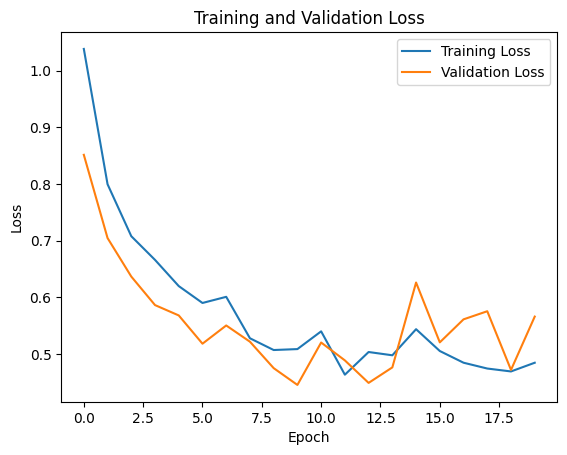

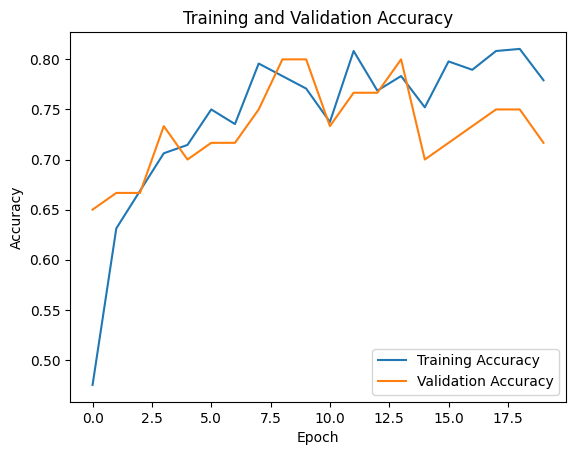

In [ ]:
def plot_history(history):
    # Plot loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot history dari model yang sudah dilatih
plot_history(history)

## **Evaluate Model 🔎**

In [ ]:
# Generate predictions and true labels for the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))

## **Save the Model** 🦺

In [ ]:
# Save the model in HDF5 format
model.save('best_model.h5')

# # If using Google Colab, use this code to download the model
# from google.colab import files

# # Download .h5 file
# files.download('best_model.h5')

## **Model Predictions 🧚🏻**

This code provided to predict image using data outside the dataset

Saving mangga12.jpg to mangga12.jpg
Saving mangga11.jpeg to mangga11.jpeg
Saving mangga10.jpeg to mangga10.jpeg
Saving mangga9x.jpeg to mangga9x.jpeg
Saving mangga9.jpg to mangga9.jpg
1/1 [==============================] - 1s 1s/step


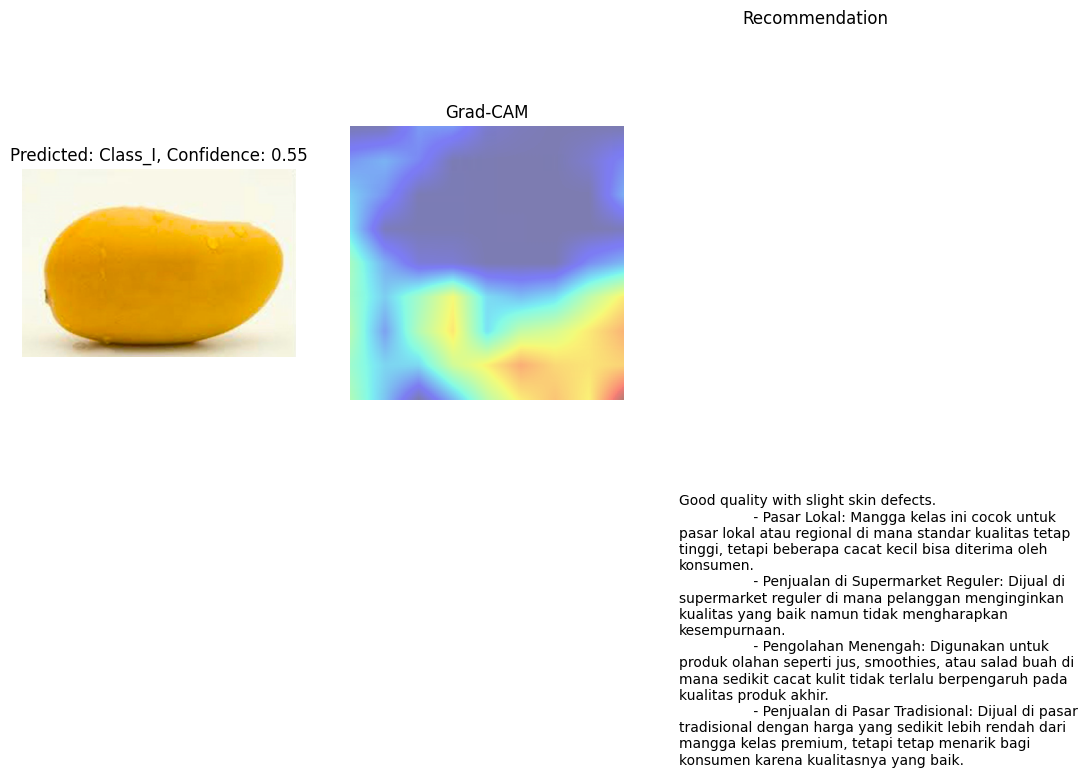

1/1 [==============================] - 0s 28ms/step


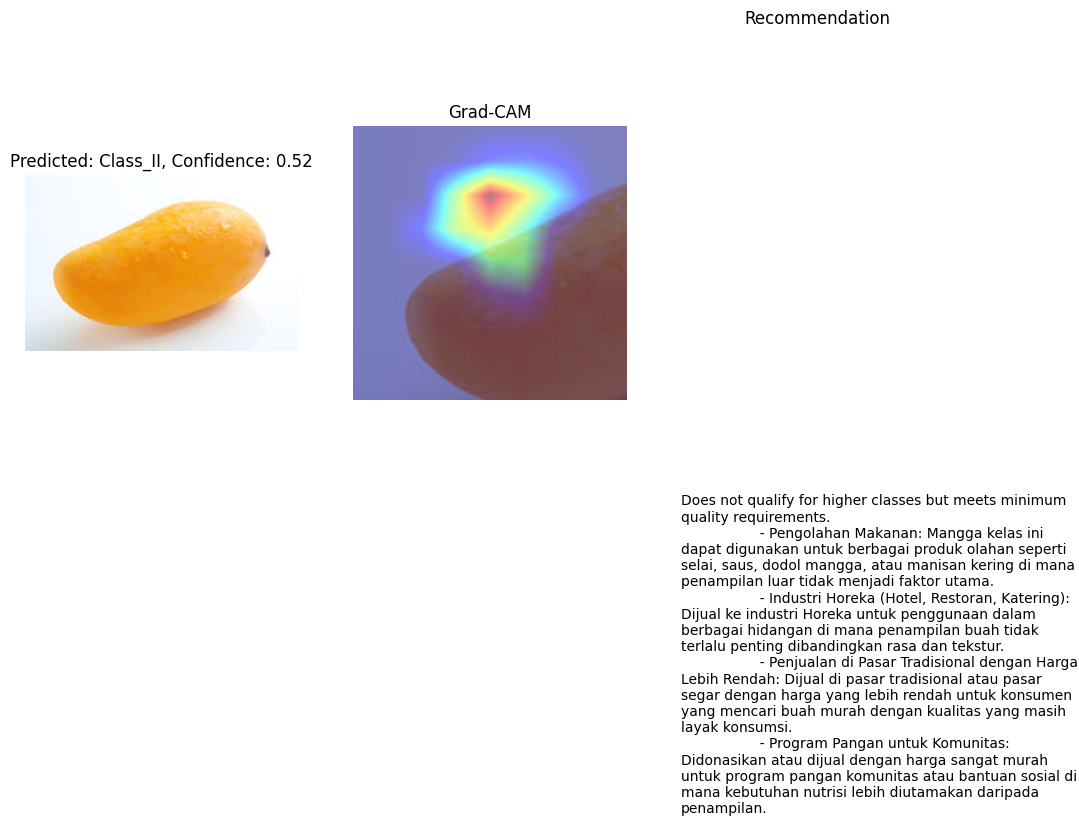

1/1 [==============================] - 0s 24ms/step


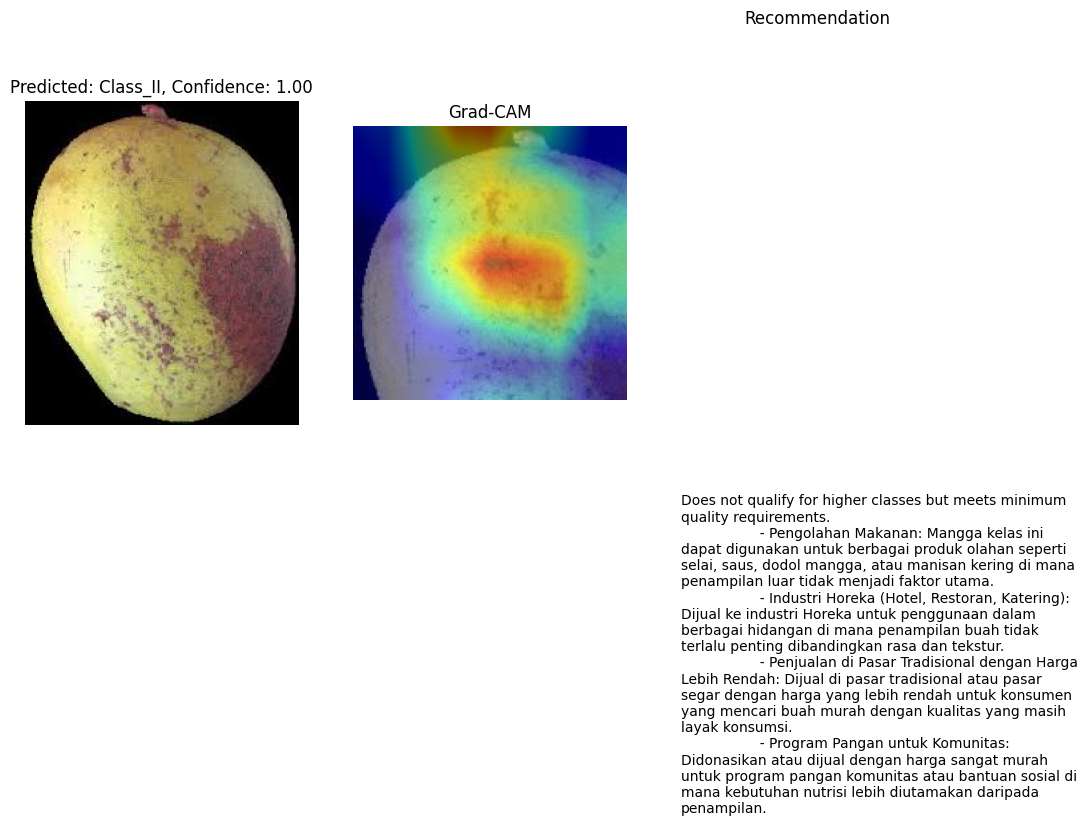

1/1 [==============================] - 0s 31ms/step


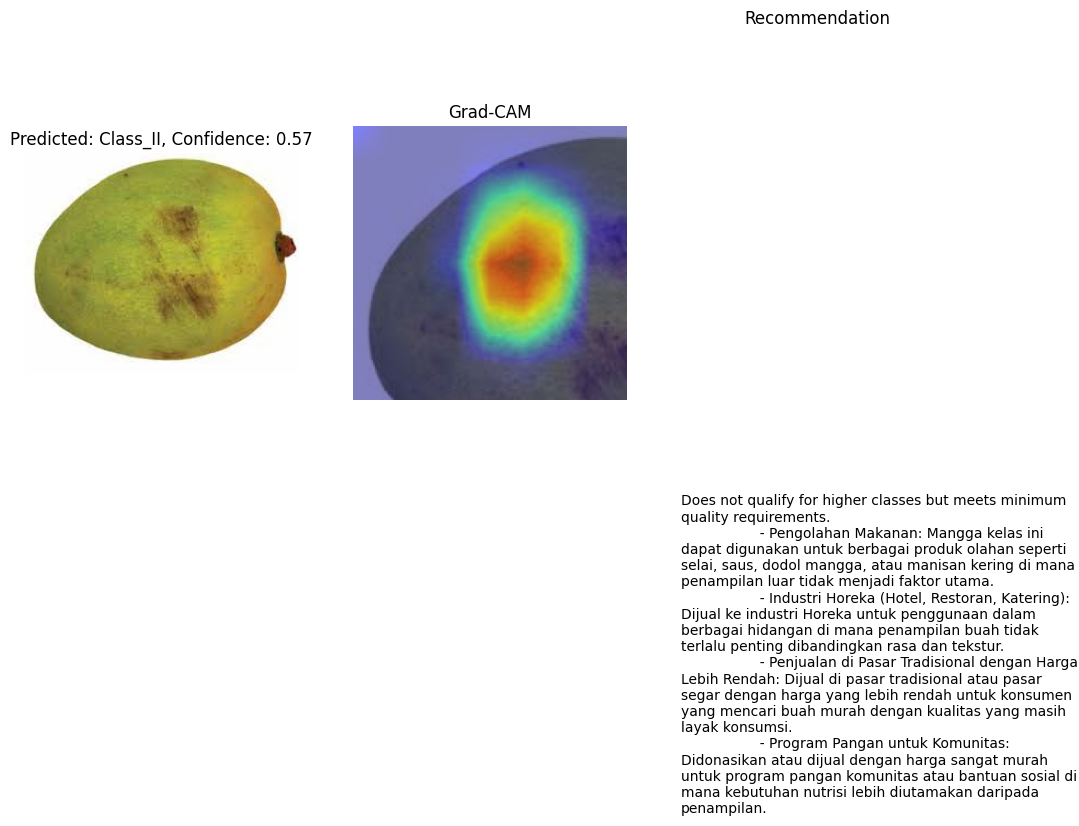

1/1 [==============================] - 0s 38ms/step


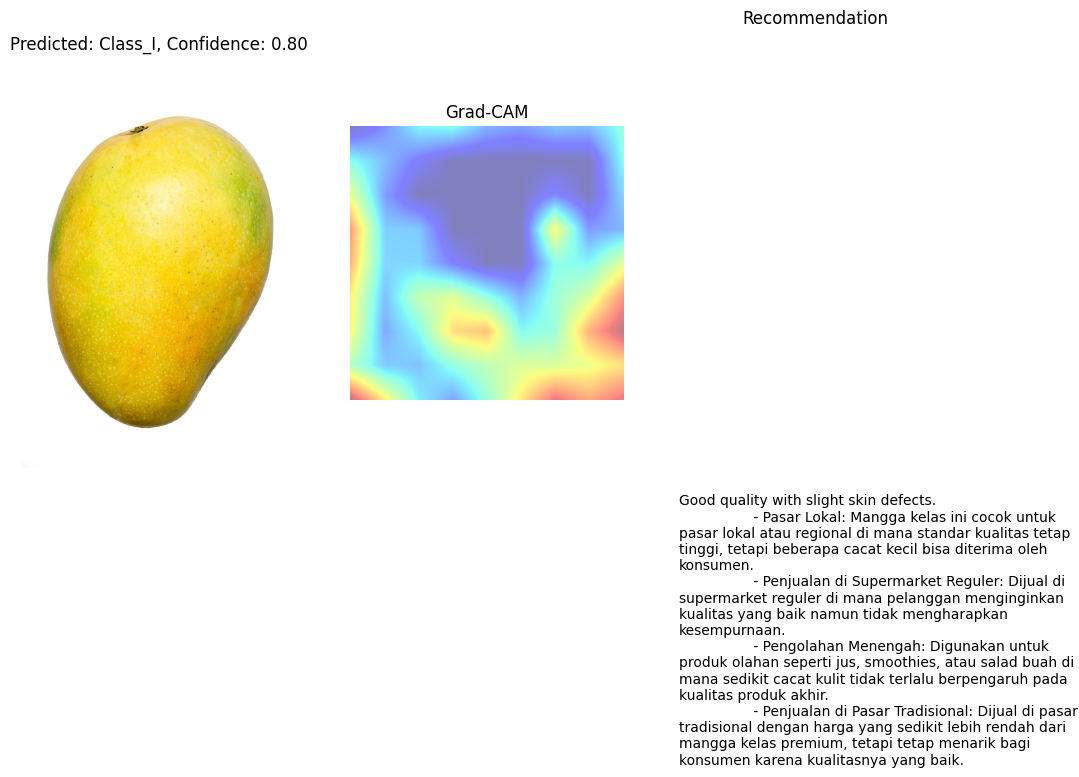

In [ ]:
# Load the trained model
model = load_model('/content/best_model.h5')

# Class name according to the data
class_names = ['Extra_Class', 'Class_II', 'Class_I']

# Recommendations by class
recommendations = {
    'Extra_Class': """Superior quality with minimal defects.
                     - Pasar Ekspor: Mangga kelas ini sangat cocok untuk pasar ekspor karena kualitasnya yang sangat tinggi dan hampir tanpa cacat. Ini bisa mendatangkan harga premium.
                     - Pasar Supermarket Premium: Dijual di supermarket atau toko buah premium yang melayani pelanggan yang mencari produk berkualitas tinggi.
                     - Hadiah dan Paket Khusus: Digunakan sebagai hadiah atau paket khusus untuk acara-acara tertentu seperti perayaan atau festival, di mana penampilan dan kualitas sangat penting.
                     - Produk Olahan Premium: Diproses menjadi produk olahan premium seperti jus mangga murni, pure mangga untuk bayi, atau selai mangga premium yang bisa dijual dengan harga lebih tinggi.""",
    'Class_I': """Good quality with slight skin defects.
                 - Pasar Lokal: Mangga kelas ini cocok untuk pasar lokal atau regional di mana standar kualitas tetap tinggi, tetapi beberapa cacat kecil bisa diterima oleh konsumen.
                 - Penjualan di Supermarket Reguler: Dijual di supermarket reguler di mana pelanggan menginginkan kualitas yang baik namun tidak mengharapkan kesempurnaan.
                 - Pengolahan Menengah: Digunakan untuk produk olahan seperti jus, smoothies, atau salad buah di mana sedikit cacat kulit tidak terlalu berpengaruh pada kualitas produk akhir.
                 - Penjualan di Pasar Tradisional: Dijual di pasar tradisional dengan harga yang sedikit lebih rendah dari mangga kelas premium, tetapi tetap menarik bagi konsumen karena kualitasnya yang baik.""",
    'Class_II': """Does not qualify for higher classes but meets minimum quality requirements.
                  - Pengolahan Makanan: Mangga kelas ini dapat digunakan untuk berbagai produk olahan seperti selai, saus, dodol mangga, atau manisan kering di mana penampilan luar tidak menjadi faktor utama.
                  - Industri Horeka (Hotel, Restoran, Katering): Dijual ke industri Horeka untuk penggunaan dalam berbagai hidangan di mana penampilan buah tidak terlalu penting dibandingkan rasa dan tekstur.
                  - Penjualan di Pasar Tradisional dengan Harga Lebih Rendah: Dijual di pasar tradisional atau pasar segar dengan harga yang lebih rendah untuk konsumen yang mencari buah murah dengan kualitas yang masih layak konsumsi.
                  - Program Pangan untuk Komunitas: Didonasikan atau dijual dengan harga sangat murah untuk program pangan komunitas atau bantuan sosial di mana kebutuhan nutrisi lebih diutamakan daripada penampilan."""
}

# Functions for loading and processing images
def load_and_preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

# Upload images
uploaded = files.upload()

# Perform Grad-CAM prediction and visualization for each uploaded image
for img_path in uploaded.keys():
    # Load and preprocess images
    img = load_and_preprocess_image(img_path)

    # Predict image class
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index]

    # Grad-CAM
    gradcam = Gradcam(model,
                      model_modifier=ReplaceToLinear(),
                      clone=True)

    # Define the score function
    score = CategoricalScore(predicted_class_index)

    # Generate heatmap with GradCAM
    heatmap = gradcam(score, img, penultimate_layer=-1)  # Check if this layer is correct

    # Plot the image and the heatmap
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image.load_img(img_path))
    plt.title(f"Predicted: {predicted_class_name}, Confidence: {confidence:.2f}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(image.load_img(img_path))
    plt.imshow(heatmap[0], cmap='jet', alpha=0.5)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.text(0, 0, recommendations[predicted_class_name], horizontalalignment='left', verticalalignment='top', wrap=True, fontsize=10)
    plt.title("Recommendation")
    plt.axis('off')

    plt.show()

    # Delete uploaded files when finished
    os.remove(img_path)

TFLITE Convert

## **TensorFlow Lite** 🔄

### **Convert to TFLite**

In [ ]:
# Load the Keras model
model = tf.keras.models.load_model('best_model.h5')

# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply optimization if needed
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model to a file
with open('Grading.tflite', 'wb') as f:
    f.write(tflite_model)

### **Evaluate TFLite**

In [ ]:
# Load the test data
test_data_dir = '/tmp/Grading_Split/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size=(150, 150),
                                            batch_size=10,
                                            class_mode='categorical',
                                            shuffle=False)

# Initialize the TensorFlow Lite interpreter
interpreter = tf.lite.Interpreter(model_path='Grading.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to run inference on a batch of data
def tflite_predict(interpreter, images):
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    predictions = []
    for img in images:
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        interpreter.set_tensor(input_index, img)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_index)
        predictions.append(output_data[0])
    return np.array(predictions)

# Prepare the test data
y_true = test_set.classes
predictions = []

for i in range(len(test_set)):
    x_batch, _ = test_set[i]
    x_batch = np.array(x_batch, dtype=np.float32)
    predictions.extend(tflite_predict(interpreter, x_batch))

predictions = np.array(predictions)

# Convert predictions to class labels
y_pred_binary = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_binary)

# Calculate precision
precision = precision_score(y_true, y_pred_binary, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred_binary, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred_binary, average='weighted')

# Print the metrics
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Found 60 images belonging to 3 classes.
Test Accuracy: 0.85
Precision: 0.848078529657477
Recall: 0.85
F1 Score: 0.848686679174484


### **TFLite Predictions**

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="Grading.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the input data
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Load an example image
image_path = '/content/mangga9x.jpeg'
input_data = preprocess_image(image_path, target_size=(150, 150))

# Compare outputs from original model and TFLite model
def compare_models(tf_model, tflite_interpreter, input_data):
    # Get prediction from original model
    tf_output = tf_model.predict(input_data)

    # Get prediction from TFLite model
    tflite_interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
    tflite_interpreter.invoke()
    tflite_output = tflite_interpreter.get_tensor(output_details[0]['index'])

    return tf_output, tflite_output

# Load the original model
tf_model = tf.keras.models.load_model('best_model.h5')

# Compare outputs
tf_output, tflite_output = compare_models(tf_model, interpreter, input_data)
print("Original Model Output:", tf_output)
print("TFLite Model Output:", tflite_output)

1/1 [==============================] - 0s 225ms/step
Original Model Output: [[0.21195874 0.786105   0.00193628]]
TFLite Model Output: [[0.21881834 0.7790276  0.00215405]]


## **TFLite Metadata Writing** ✍🏻

In [ ]:
ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "Grading.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "label.txt"
_SAVE_TO_PATH = "Grading_with_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 0.5 # ini ga yakin banget, soalnya kita normalisasi ke range [0,1] --> rescale(1/255.)
_INPUT_NORM_STD = 0.5 # ini ga yakin banget, soalnya kita normalisasi ke range [0,1] --> rescale(1/255.)

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  0.5
                ],
                "std": [
                  0.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              509.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "probabi

## **Camera Capture 🎥**

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 142ms/step


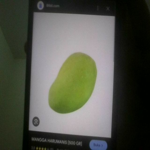

Predicted: Extra_Class


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 17ms/step


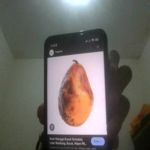

Predicted: Class_II


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 21ms/step


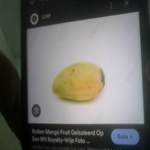

Predicted: Class_II


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 18ms/step


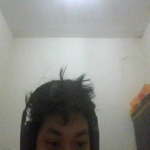

Predicted: Class_II


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
# Function to activate the camera and get frames from the camera
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Capture the image and stop video streaming
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Load the model
model = tf.keras.models.load_model('best_model.h5')

# Define the categories
categories = ['Class_I', 'Class_II', 'Extra_Class']

# Main function to capture image, predict, and display result
def predict_from_camera():
    while True:
        try:
            # Capture image from camera
            filename = take_photo()

            # Load and preprocess image
            img = Image.open(filename)
            img = img.resize((150, 150))
            img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

            # Perform prediction
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)
            predicted_label = categories[predicted_class[0]]

            # Display the image and prediction result
            display(img)
            print(f'Predicted: {predicted_label}')

            # Sleep for a while before capturing the next image
            time.sleep(1)
        except Exception as e:
            print(str(e))

# Call the main function
predict_from_camera()